In [255]:
import numpy as np
import matplotlib.pyplot as plt
import powerlaw

def bak_sneppen_1D(n_iterations, skip_iterations, n_species, local_segment=[0,0]):
    # Initialize the system
    fitness = np.random.rand(n_species)
    threshold = 0.6
    gap_function_value = 0
    min_fitness = np.zeros(n_iterations - skip_iterations)
    fitness_history = []
    avalanche_sizes_local = []
    avalanche_sizes_global = []
    avalanche_activity_local = []
    avalanche_activity_global = []
    avalanche = False
    avalanche_size_local = 0
    avalanche_size_global = 0

    for i in range(n_iterations):
        # species with minimum fitness value
        min_index = np.argmin(fitness)

        # assign a new random fitness value to the selected species
        fitness[min_index] = np.random.rand()

        # check neighbors and update their fitness if below the threshold
        if min_index > 0:
            fitness[min_index - 1] = np.random.rand()
        if min_index < n_species - 1:
            fitness[min_index + 1] = np.random.rand()
        # periodic boundary
        elif min_index == n_species -1:
            fitness[0] = np.random.rand()

        min_fitness_value = np.min(fitness)
        # if min_fitness_value > gap_function_value:
        #     gap_function_value = min_fitness_value
        #     # print(f'{gap_function_value}, iteration: {i}')
        #     threshold = gap_function_value - 0.01
        
        # skip iterations to start at the critical state
        if i >= skip_iterations:
            fitness_history.append(fitness)
            

            # save minimum fitness for each iteration
            min_fitness[i - skip_iterations] = min_fitness_value

            # if avalanche in progress
            if min_fitness_value < threshold and avalanche == True:
                # seperate counter for local activity
                if min_index >= local_segment[0] and min_index < local_segment[1]:
                    avalanche_size_local += 1
                    avalanche_activity_local.append(i-skip_iterations)

                avalanche_size_global += 1
                avalanche_activity_global.append(i-skip_iterations)

            # start of new avalanche
            if min_fitness_value < threshold and avalanche == False:
                # print(f'avalanche start i: {i}')
                # avalanche_size += 1
                avalanche = True

            # end of an avalanche
            if min_fitness_value >= threshold and avalanche == True:
                # print(f'avalanche end i: {i}')

                avalanche_sizes_local.append(avalanche_size_local)
                avalanche_sizes_global.append(avalanche_size_global)
                avalanche_size_local = 0
                avalanche_size_global = 0
                avalanche = False


    return min_fitness, fitness_history, avalanche_sizes_global, avalanche_sizes_local, avalanche_activity_global, avalanche_activity_local



In [239]:
# Run the Bak-Sneppen simulation
n_iterations = 10000000
skip_iterations = 200000
local_segment = [20,220]
n_species = 1000
avalanche_sizes_local = [0,0]

counter = 0
while sum(x != 0 for x in avalanche_sizes_local) < 50:
    counter += 1
    print(f'{counter}, {sum(x != 0 for x in avalanche_sizes_local)}', end='\r')
    min_fitness, fitness_history, avalanche_sizes_global, avalanche_sizes_local, avalanche_activity_global, avalanche_activity_local = bak_sneppen_1D(n_iterations, skip_iterations, n_species, local_segment)


14287


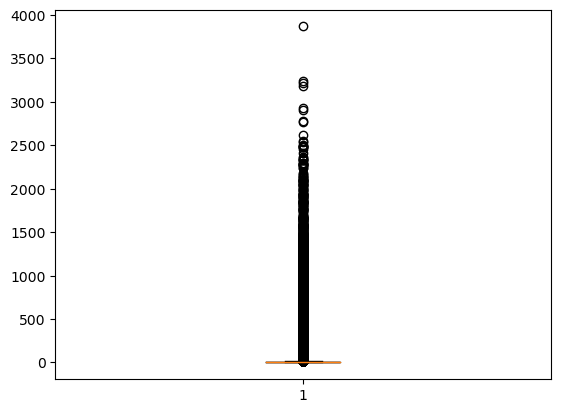

In [240]:
print(sum(x != 0 for x in avalanche_sizes_local))
plt.boxplot(avalanche_sizes_local)
plt.show()

Local avalanche activity

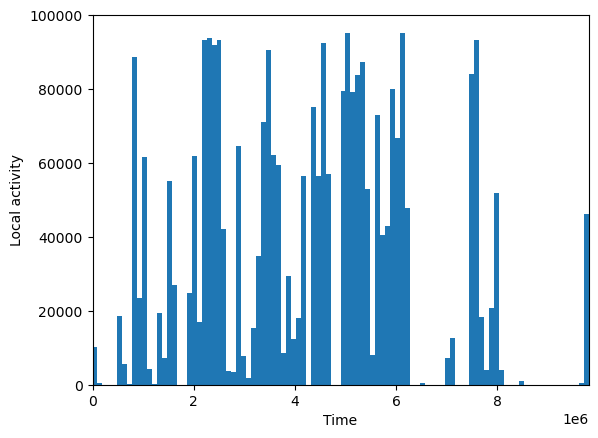

In [241]:
# plot avalanche activity in time
plt.hist(avalanche_activity_local, bins=100)
plt.xlim(0,n_iterations-skip_iterations)
plt.xlabel('Time')
plt.ylabel('Local activity')
plt.show()

Avalanche size distribution

[10316, 4131, 2766, 2198, 1771, 1519, 1267, 1116, 994, 910, 880, 843, 733, 728, 708, 579, 611, 490, 517, 512, 489, 426, 408, 409, 390, 403, 337, 300, 284, 278, 320, 288, 265, 261, 247, 236, 258, 231, 201, 195, 187, 196, 205, 195, 170, 171, 171, 166, 158, 147, 154, 135, 152, 146, 129, 124, 128, 127, 122, 117, 96, 89, 100, 110, 93, 92, 101, 96, 90, 86, 86, 85, 93, 71, 70, 76, 78, 83, 76, 48, 73, 61, 74, 47, 52, 67, 49, 51, 61, 50, 37, 50, 46, 42, 39, 45, 55, 44, 32, 37, 39, 29, 23, 34, 39, 50, 33, 22, 29, 38, 31, 39, 34, 27, 33, 37, 32, 20, 22, 30, 27, 25, 25, 21, 16, 29, 21, 25, 21, 16, 23, 13, 21, 16, 21, 12, 19, 15, 21, 17, 16, 19, 28, 12, 12, 16, 13, 16, 12, 9, 7, 14, 13, 13, 10, 11, 18, 18, 15, 11, 7, 8, 6, 11, 7, 8, 10, 13, 11, 5, 12, 5, 7, 7, 7, 4, 13, 7, 5, 8, 6, 4, 7, 8, 10, 6, 7, 3, 2, 6, 5, 3, 2, 3, 7, 5, 6, 4, 5, 3, 5, 4, 3, 6, 6, 3, 3, 2, 4, 3, 8, 4, 2, 3, 2, 5, 2, 6, 1, 1, 1, 3, 6, 5, 5, 4, 6, 4, 5, 3, 2, 1, 1, 3, 1, 1, 2, 2, 2, 1, 3, 2, 3, 1, 3, 5, 2, 2, 1, 2, 2, 1, 2, 2, 

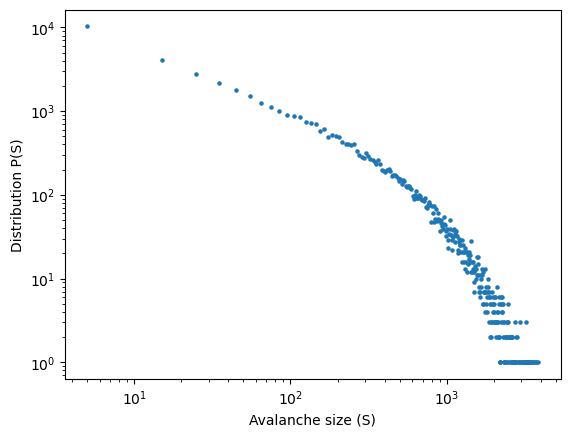

In [245]:
# bins of avalanche sizes
bins = [x for x in np.arange(0,np.max(avalanche_sizes_global),10)]
all_bins = [x for x in np.arange(5,np.max(avalanche_sizes_global) - 10,10)]
avalanche_size_distribution, _ = np.histogram(avalanche_sizes_global, bins)

# remove bins were value is zero
avalanche_size_distribution_plot = []
bins_plot = []
for i in range(len(avalanche_size_distribution)):
    if avalanche_size_distribution[i] != 0:
        avalanche_size_distribution_plot.append(avalanche_size_distribution[i])
        bins_plot.append(all_bins[i])




print(avalanche_size_distribution_plot)
print(bins_plot)
print(len(avalanche_sizes_global))


plt.scatter(bins_plot, avalanche_size_distribution_plot, s=5)
# plt.hist(avalanche_sizes_global, bins=100)
plt.xlabel('Avalanche size (S)')
plt.ylabel('Distribution P(S)')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [252]:
# run simulation for different system sizes to compare
system_sizes = [32, 128, 512, 2048]
n_iterations = 10000000
skip_iterations = 200000

avalanche_sizes_list = []

for n_species in system_sizes:
    min_fitness, fitness_history, avalanche_sizes_global, avalanche_sizes_local, avalanche_activity_global, avalanche_activity_local = bak_sneppen_1D(n_iterations, skip_iterations, n_species, local_segment)
    avalanche_sizes_list.append(avalanche_sizes_global)


[14841, 6143, 4146, 3105, 2606, 2129, 1796, 1639, 1567, 1354, 1231, 1110, 1047, 949, 905, 815, 802, 716, 740, 607, 600, 566, 536, 525, 465, 476, 478, 434, 386, 410, 379, 367, 342, 343, 298, 289, 301, 307, 283, 258, 255, 251, 219, 218, 235, 225, 172, 206, 194, 177, 157, 159, 159, 150, 155, 110, 128, 140, 131, 117, 126, 125, 116, 93, 98, 112, 112, 109, 96, 109, 96, 90, 84, 83, 75, 62, 64, 73, 51, 58, 57, 65, 52, 42, 65, 49, 47, 39, 40, 44, 42, 48, 34, 45, 47, 30, 26, 34, 36, 43, 28, 23, 30, 33, 22, 22, 18, 19, 26, 23, 34, 19, 25, 19, 21, 20, 18, 15, 18, 12, 21, 18, 16, 12, 14, 14, 13, 10, 6, 10, 13, 7, 13, 10, 13, 16, 10, 12, 15, 10, 7, 8, 12, 10, 11, 5, 11, 3, 4, 7, 4, 5, 4, 4, 4, 5, 3, 3, 6, 6, 4, 3, 3, 2, 6, 6, 4, 1, 4, 4, 5, 1, 3, 7, 2, 3, 5, 2, 5, 4, 2, 6, 2, 3, 6, 1, 3, 2, 2, 1, 4, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1]
[5, 15, 25, 35, 45, 55, 65, 75, 85, 95, 105, 115, 125, 135, 145, 155, 165, 175, 185, 195, 205, 215, 225, 235, 245, 255, 265, 275, 2

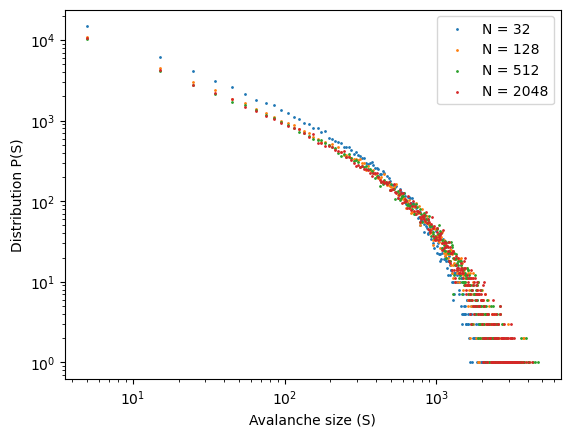

In [254]:
system_sizes = [32, 128, 512, 2048]

for i in range(len(avalanche_sizes_list)):
    # bins of avalanche sizes
    bins = [x for x in np.arange(0,np.max(avalanche_sizes_list[i]),10)]
    all_bins = [x for x in np.arange(5,np.max(avalanche_sizes_list[i]) - 10,10)]
    avalanche_size_distribution, _ = np.histogram(avalanche_sizes_list[i], bins)

    # remove bins were value is zero
    avalanche_size_distribution_plot = []
    bins_plot = []
    for j in range(len(avalanche_size_distribution)):
        if avalanche_size_distribution[j] != 0:
            avalanche_size_distribution_plot.append(avalanche_size_distribution[j])
            bins_plot.append(all_bins[j])


    # print(avalanche_size_distribution_plot)
    # print(bins_plot)
    # print(len(avalanche_sizes_global))
    

    plt.scatter(bins_plot, avalanche_size_distribution_plot, label=f'N = {system_sizes[i]}', s=1)
    plt.xlabel('Avalanche size (S)')
    plt.ylabel('Distribution P(S)')
    plt.xscale('log')
    plt.yscale('log')
plt.legend()
plt.show()

Power law fit

302
302
70
70


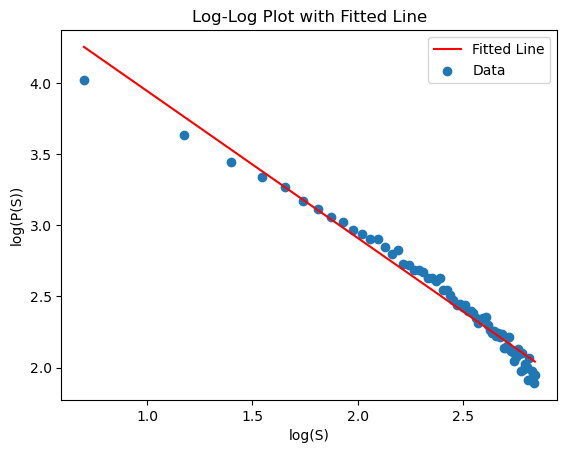

Exponent: -1.0325829090175775


In [272]:
import numpy as np
import matplotlib.pyplot as plt

bins = [x for x in np.arange(0,np.max(avalanche_sizes_list[i]),10)]
all_bins = [x for x in np.arange(5,np.max(avalanche_sizes_list[i]) - 10,10)]
avalanche_size_distribution, _ = np.histogram(avalanche_sizes_list[3], bins)

# remove bins were value is zero
avalanche_size_distribution_plot = []
bins_plot = []
for j in range(len(avalanche_size_distribution)):
    if avalanche_size_distribution[j] != 0:
        avalanche_size_distribution_plot.append(avalanche_size_distribution[j])
        bins_plot.append(all_bins[j])


print(len(bins_plot))
print(len(avalanche_size_distribution_plot))


threshold = 700

bins_filtered = [value1 for value1 in bins_plot if value1 <= threshold]
avalanche_sizes_global_filtered = [value2 for value1, value2 in zip(bins_filtered, avalanche_size_distribution_plot) if value1 <= threshold]

print(len(bins_filtered))
print(len(avalanche_sizes_global_filtered))


# Take the logarithm of the filtered data
log_bins = np.log10(bins_filtered)
log_sizes = np.log10(avalanche_sizes_global_filtered)

# Fit a straight line through linear regression
coefficients = np.polyfit(log_bins, log_sizes, 1)
exponent = coefficients[0]

# Generate the fitted line
fit_x = np.linspace(min(log_bins), max(log_bins), 100)
fit_y = coefficients[0] * fit_x + coefficients[1]

# Plot the log-log data and the fitted line
plt.scatter(log_bins, log_sizes, label='Data')
plt.plot(fit_x, fit_y, 'r-', label='Fitted Line')
plt.xlabel('log(S)')
plt.ylabel('log(P(S))')
plt.title('Log-Log Plot with Fitted Line')
plt.legend()
plt.show()

# Print the exponent of the fitted line
print("Exponent:", exponent)

In [262]:

filtered_list = [value for value in avalanche_sizes_list[3] if value <= 1400]
results = powerlaw.Fit(filtered_list)

# Print the estimated exponent and lower bound of the power law distribution
print("Estimated exponent (alpha):", results.power_law.alpha)
print("Estimated lower bound (xmin):", results.power_law.xmin)
print(f"exponent error: {results.power_law.sigma}")

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Estimated exponent (alpha): 3.1904519128912083
Estimated lower bound (xmin): 452.0
exponent error: 0.028607096200813503


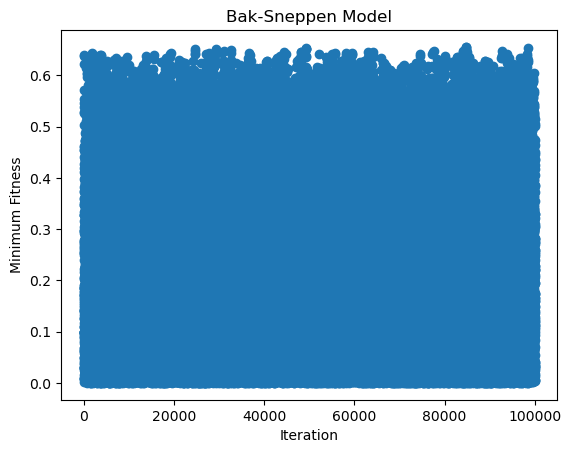

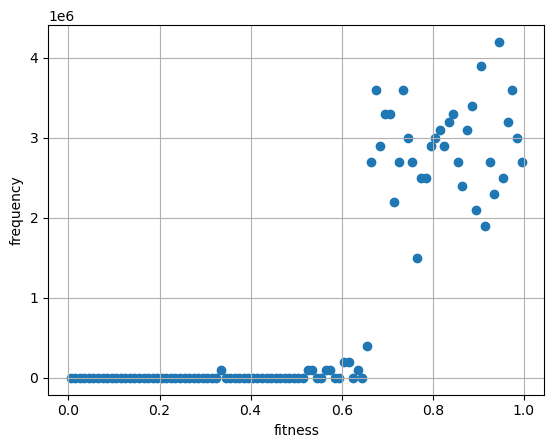

In [92]:

# Plot the evolution of the minimum fitness value
plt.scatter(range(n_iterations - skip_iterations), min_fitness)
plt.xlabel('Iteration')
plt.ylabel('Minimum Fitness')
plt.title('Bak-Sneppen Model')
plt.show()

bins = np.arange(0,1.01,0.01)
bins_plot = np.arange(0.005,1.005,0.01)
counts = np.zeros(len(bins)-1)

# Plot the distribution of fitness during the whole simulation
for fitness_slice in fitness_history:
    counts_slice, _ = np.histogram(fitness_slice, bins)
    counts = [x + y for x, y in zip(counts, counts_slice)]

# Plot the normalized distribution using a histogram
plt.scatter(bins_plot, counts)
plt.xlabel('fitness')
plt.ylabel('frequency')
plt.grid(True)
plt.show()


In [65]:
def bak_sneppen_2D(n_iterations, grid_size=50):
    # Initialize the system

    fitness = np.random.rand(grid_size, grid_size)
    threshold = 0.5
    evolution = np.zeros(n_iterations)

    # Simulation loop
    for i in range(n_iterations):
        # Find the site with the minimum fitness value
        min_index = np.argmin(fitness)

        # Assign a new random fitness value to the selected site
        fitness[min_index] = np.random.rand()

        # Check neighbors and update their fitness if below the threshold
        if min_index > 0 and fitness[min_index - 1] < threshold:
            fitness[min_index - 1] = np.random.rand()
        if min_index < n_species - 1 and fitness[min_index + 1] < threshold:
            fitness[min_index + 1] = np.random.rand()

        # Record the minimum fitness value at each iteration
        evolution[i] = np.min(fitness)

    return evolution

# Run the Bak-Sneppen simulation
n_iterations = 100000
evolution = bak_sneppen_2D(n_iterations)

# Plot the evolution of the minimum fitness value
plt.plot(range(n_iterations), evolution)
plt.xlabel('Iteration')
plt.ylabel('Minimum Fitness')
plt.title('Bak-Sneppen Model')
plt.show()


In [20]:
l1 = np.array([1,2,3])
l2 = np.array([1,2,3])

l1 = [x + y for x, y in zip(l1, l2)]
print(l1)

[2, 4, 6]
